<a href="https://colab.research.google.com/github/Yaya-Ousman/Projet-Choix-de-mod-le-et-GLM/blob/main/Projet__Final_DL_YAYA_Ousman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rapport de projet de Deep learning
### Réalisé par: YAYA Ousman
### Université Paris Dauphine-PSL
### Executive Master Statistiques et Big data(EMSB_BT07)

###Problematique
Comment construire un modèle de Deep Learning capable de distinguer avec précision les visages de Keira Knightley, Natalie Portman et d'autres actrices, malgré les fortes similarités faciales et la variabilité des images issues d'internet ?

#### Chargement des bibliothèques necessaires

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


#### Importation de données depuis mon drive

In [ ]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Définition des chemins de base dans Google Drive
base_train_path = "/content/drive/My Drive/train"
base_validation_path = "/content/drive/My Drive/val"
base_test_path = "/content/drive/My Drive/test"

# Définition des chemins spécifiques pour chaque classe
train_keira_path = f"{base_train_path}/keira"
train_nathalie_path = f"{base_train_path}/nathalie"
train_others_path = f"{base_train_path}/others"

validation_keira_path = f"{base_validation_path}/keira"
validation_nathalie_path = f"{base_validation_path}/nathalie"
validation_others_path = f"{base_validation_path}/others"

test_keira_path = f"{base_test_path}/keira"
test_nathalie_path = f"{base_test_path}/nathalie"
test_others_path = f"{base_test_path}/others"

# Vérification des chemins
print(" Train Keira Path:", train_keira_path)
print(" Train Nathalie Path:", train_nathalie_path)
print(" Train Others Path:", train_others_path)

print(" Validation Keira Path:", validation_keira_path)
print(" Validation Nathalie Path:", validation_nathalie_path)
print(" Validation Others Path:", validation_others_path)

print(" Test Keira Path:", test_keira_path)
print(" Test Nathalie Path:", test_nathalie_path)
print(" Test Others Path:", test_others_path)


 Train Keira Path: /content/drive/My Drive/train/keira
 Train Nathalie Path: /content/drive/My Drive/train/nathalie
 Train Others Path: /content/drive/My Drive/train/others
 Validation Keira Path: /content/drive/My Drive/val/keira
 Validation Nathalie Path: /content/drive/My Drive/val/nathalie
 Validation Others Path: /content/drive/My Drive/val/others
 Test Keira Path: /content/drive/My Drive/test/keira
 Test Nathalie Path: /content/drive/My Drive/test/nathalie
 Test Others Path: /content/drive/My Drive/test/others


In [ ]:
import os

# Vérification du contenu des datasets
print(" Train :", os.listdir(base_train_path))
print(" Validation :", os.listdir(base_validation_path))
print(" Test :", os.listdir(base_test_path))



 Train : ['others', 'nathalie', 'keira']
 Validation : ['keira', 'nathalie', 'others']
 Test : ['others', 'nathalie', 'keira']


In [ ]:
# Largeur des images en pixels (dimensions d'entrée du modèle)
IMG_WIDTH = 150

# Hauteur des images en pixels
IMG_HEIGHT = 150

# Nombre d'images traitées simultanément lors de l'entraînement
BATCH_SIZE = 32


In [ ]:
# Générateur d'images pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode="nearest"
)

# Chargement des images depuis le répertoire d'entraînement
train_generator = train_datagen.flow_from_directory(
    base_train_path,  # Chemin correct pour le dataset d'entraînement
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)



Found 429 images belonging to 3 classes.


In [ ]:
# Générateur d'images pour la validation
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Chargement des images depuis le répertoire de validation
val_generator = val_datagen.flow_from_directory(
    base_validation_path,  # Chemin correct pour le dataset de validation
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)



Found 168 images belonging to 3 classes.


In [ ]:
# Générateur d'images pour le test
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Chargement des images depuis le répertoire de test
test_generator = test_datagen.flow_from_directory(
    base_test_path,  # Chemin correct pour le dataset de test
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 168 images belonging to 3 classes.


### Géneratuer d'images

In [ ]:
# Création d'un dictionnaire pour mapper les indices aux noms des classes
labels = {value: key for key, value in train_generator.class_indices.items()}

# Affichage des correspondances entre les indices et les classes présentes dans le dataset d'entraînement
print("Label mappings for classes present in the training dataset\n")
for key, value in labels.items():
    print(f"{key} : {value}")



Label mappings for classes present in the training dataset

0 : keira
1 : nathalie
2 : others


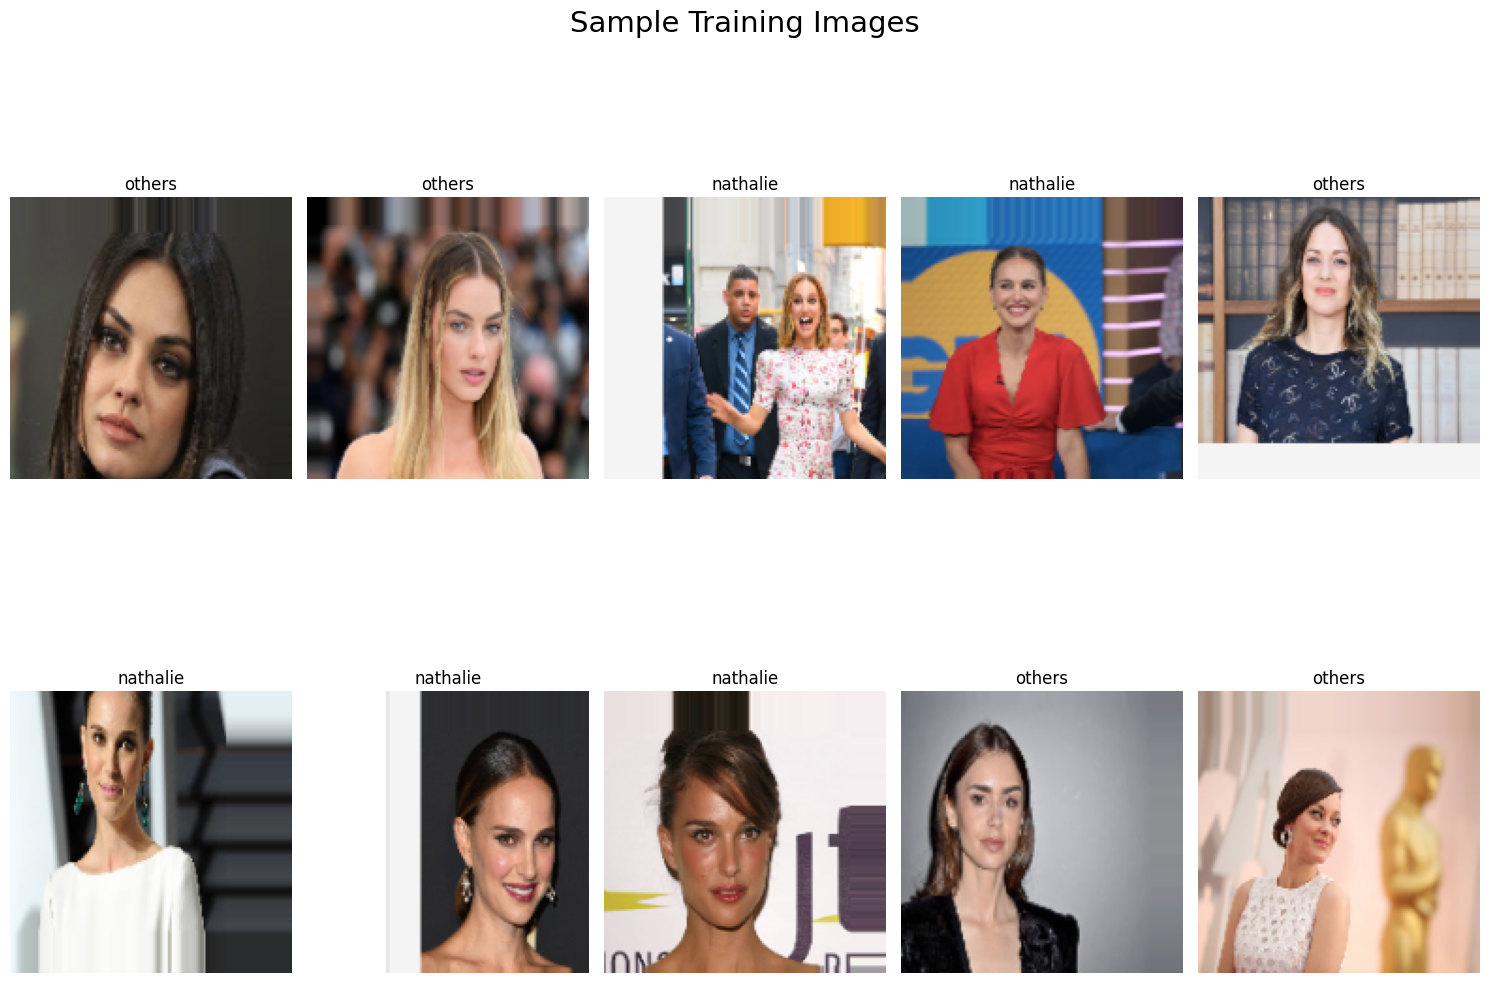

In [ ]:
# Création d'une figure pour afficher 10 images (2 lignes, 5 colonnes)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

# Récupérer un batch d'images et de labels depuis le générateur
batch = next(train_generator)

for i in range(2):
    for j in range(5):
        if idx >= batch[0].shape[0]:  # Vérification pour éviter IndexError si le batch est plus petit
            ax[i, j].axis("off")  # Masquer les cases vides
            continue

        label = labels[np.argmax(batch[1][idx])]  # Récupérer le label de l'image
        ax[i, j].set_title(f"{label}")  # Ajouter le titre avec la classe
        ax[i, j].imshow(batch[0][idx])  # Afficher l'image
        ax[i, j].axis("off")  # Supprimer les axes
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()


## Création du modèle CNN

In [ ]:
# Fonction pour créer un modèle CNN simple en utilisant Keras Sequential API
def create_model():
    model = Sequential([

        # Première couche de convolution avec 32 filtres 3x3 et fonction d'activation ReLU
        Conv2D(filters=32, kernel_size=(3, 3), input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),  # Première couche de max pooling

        # Deuxième couche de convolution avec 64 filtres
        Conv2D(filters=64, kernel_size=(3, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Troisième couche de convolution avec 128 filtres
        Conv2D(filters=128, kernel_size=(3, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Quatrième couche de convolution avec 128 filtres
        Conv2D(filters=128, kernel_size=(3, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Aplatir les cartes de caractéristiques avant les couches denses
        Flatten(),

        # Couche entièrement connectée avec 512 neurones et ReLU
        Dense(units=512, activation='relu'),
        Dropout(0.5),  # Dropout pour éviter le surapprentissage

        # Couche de sortie avec 3 neurones (pour 3 classes) et activation softmax
        Dense(units=3, activation='softmax')
    ])

    return model


In [ ]:
# Création d'une instance du modèle CNN défini précédemment
cnn_model = create_model()


In [ ]:
# Affiche un résumé du modèle : architecture, nombre de paramètres et dimensions des couches
print(cnn_model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 148, 148, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 72, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,454,147 (13.18 MB)

 Trainable params: 3,454,147 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

None


## Appliquons la méthode compile au modéle CNN

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

# Compilation du modèle
cnn_model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])


## Entrainement du modèle
Pour éviter que notre modèle ne continue d'apprendre inutilement et améliorer son entraînement, nous avons intégré **l'early stopping** qui est efficace pour:
Empêchr **l'overfitting** en arrêtant l'entraînement lorsque val_loss ne s'améliore plus.
Éviter de gaspiller du temps de calcul sur des epochs inutiles et
restaurer automatiquement les poids du meilleur modèle trouvé durant l'entraînement.

In [ ]:
# Entraîne le modèle sur les données d'entraînement avec validation à chaque époque, pendant 50 époques
epochs_size = 50
history = cnn_model.fit(train_generator, validation_data=val_generator, epochs=epochs_size)




Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.3302 - loss: 1.1234 - val_accuracy: 0.3333 - val_loss: 1.0984
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.3461 - loss: 1.0980 - val_accuracy: 0.3333 - val_loss: 1.0996
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.3277 - loss: 1.0958 - val_accuracy: 0.3452 - val_loss: 1.0966
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3580 - loss: 1.0963 - val_accuracy: 0.3810 - val_loss: 1.0825
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.3526 - loss: 1.0816 - val_accuracy: 0.4048 - val_loss: 1.0796
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4261 - loss: 1.0863 - val_accuracy: 0.3750 - val_loss: 1.0966
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.3701 - loss: 1.0742 - val_accuracy: 0.3869 - val_loss: 1.0725
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.3793 - loss: 1.0639 - val_accuracy: 0.4107 - val_loss:

In [ ]:
# Récupération des valeurs d'accuracy et de perte pour l'entraînement et la validation à chaque époque
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']


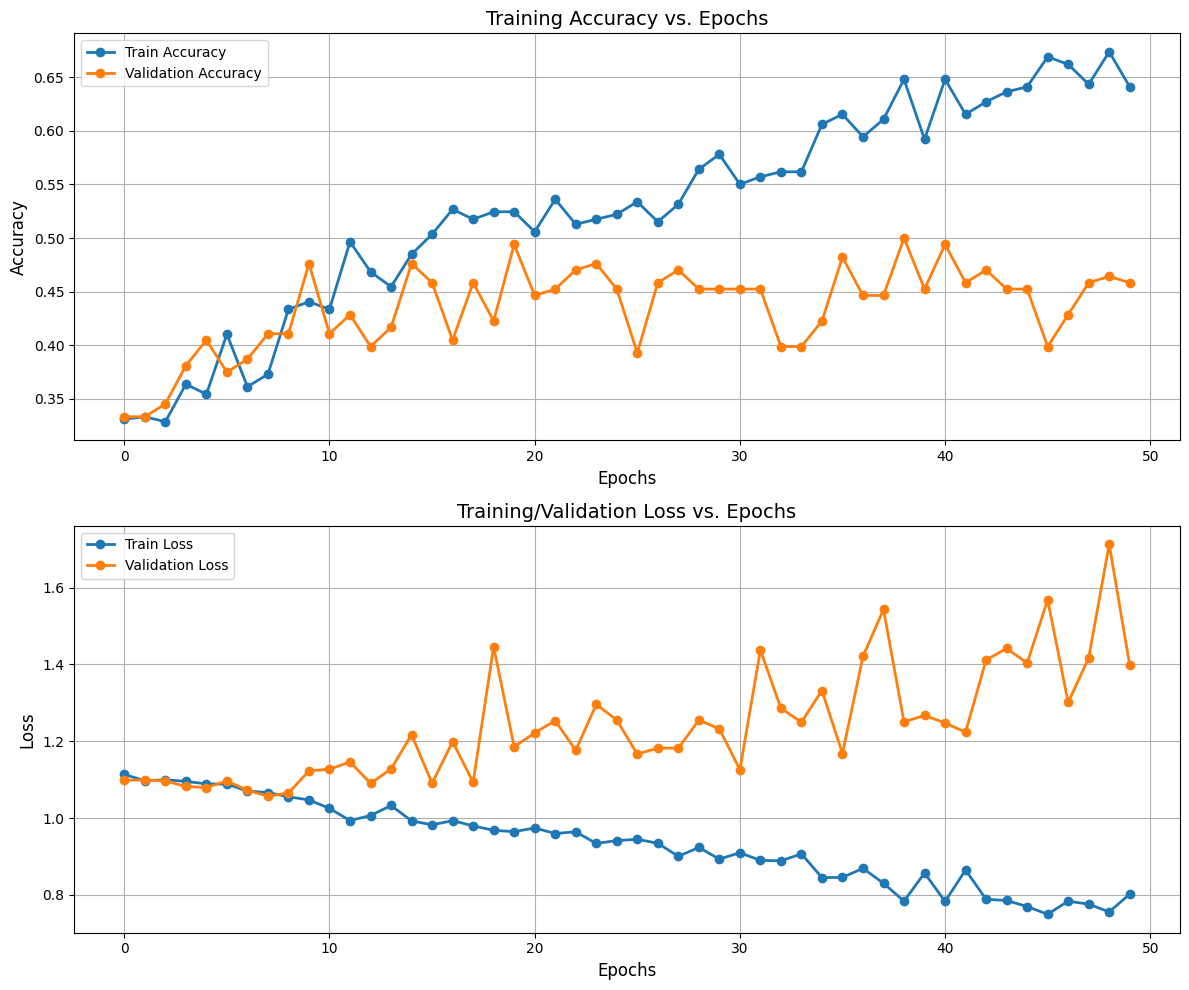

In [ ]:
# Création de deux sous-graphes pour visualiser l'évolution de l'accuracy et de la perte
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Graphe de l'accuracy
ax[0].set_title('Training Accuracy vs. Epochs', fontsize=14)  # Titre du graphe
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy', linewidth=2)  # Courbe accuracy entraînement
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy', linewidth=2)  # Courbe accuracy validation
ax[0].set_xlabel('Epochs', fontsize=12)  # Légende axe x
ax[0].set_ylabel('Accuracy', fontsize=12)  # Légende axe y
ax[0].legend(loc='best')  # Légende automatique
ax[0].grid(True)  # Grille

# Graphe de la perte (loss)
ax[1].set_title('Training/Validation Loss vs. Epochs', fontsize=14)
ax[1].plot(train_loss, 'o-', label='Train Loss', linewidth=2)
ax[1].plot(val_loss, 'o-', label='Validation Loss', linewidth=2)
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].legend(loc='best')
ax[1].grid(True)

# Ajustement automatique de l'affichage des sous-graphes
plt.tight_layout()
plt.show()


Le modèle montre un surapprentissage, l'accuracy d'entraînement continue d'augmenter tandis que celle de validation stagne, et la perte de validation fluctue fortement.

In [ ]:
predictions = cnn_model.predict(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 930ms/step


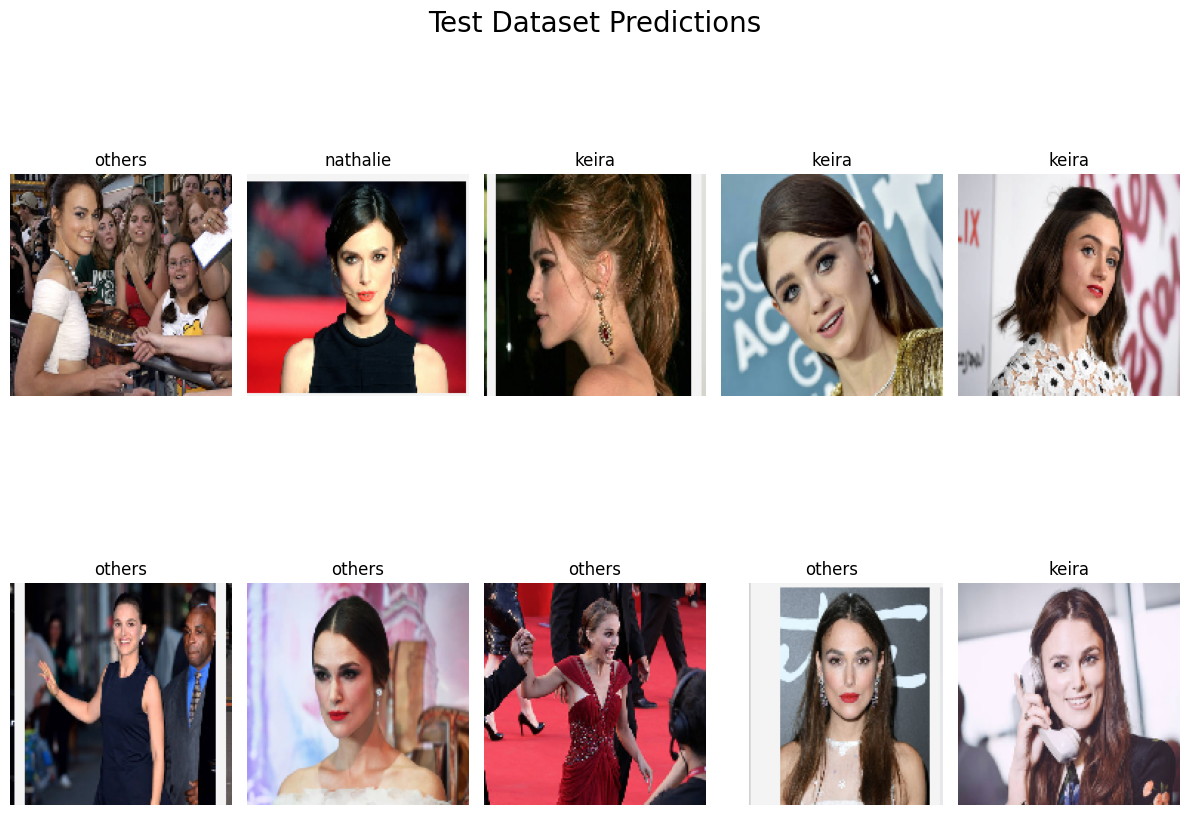

In [ ]:
# Création d'une grille de 2 lignes × 5 colonnes pour afficher 10 images
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0  # Index pour parcourir les images du batch

# Boucle pour remplir la grille avec les images et leurs prédictions
for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]  # Récupération de la classe prédite
        ax[i, j].set_title(f"{predicted_label}")  # Titre = label prédit
        ax[i, j].imshow(test_generator[0][0][idx])  # Affichage de l'image
        ax[i, j].axis("off")  # Suppression des axes
        idx += 1  # Passage à l'image suivante

# Réduction des espaces entre les subplots
plt.tight_layout()

# Titre global du graphe
plt.suptitle("Test Dataset Predictions", fontsize=20)

# Affichage du graphe
plt.show()


In [ ]:
# Évaluation du modèle sur l'ensemble de test : retourne la perte et l'accuracy
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 814ms/step - accuracy: 0.4793 - loss: 1.3656


Avec un accuracy de 47.93%, la performance du modèle est limité. Nous allons chercher à l'améliorer en utilisant d'autres techniques et methodes.

In [ ]:
# Récupère les indices des classes prédites (classe avec la plus forte probabilité pour chaque image)
y_pred = np.argmax(predictions, axis=1)

# Récupère les vraies étiquettes des images du jeu de test à partir du générateur
y_true = test_generator.classes


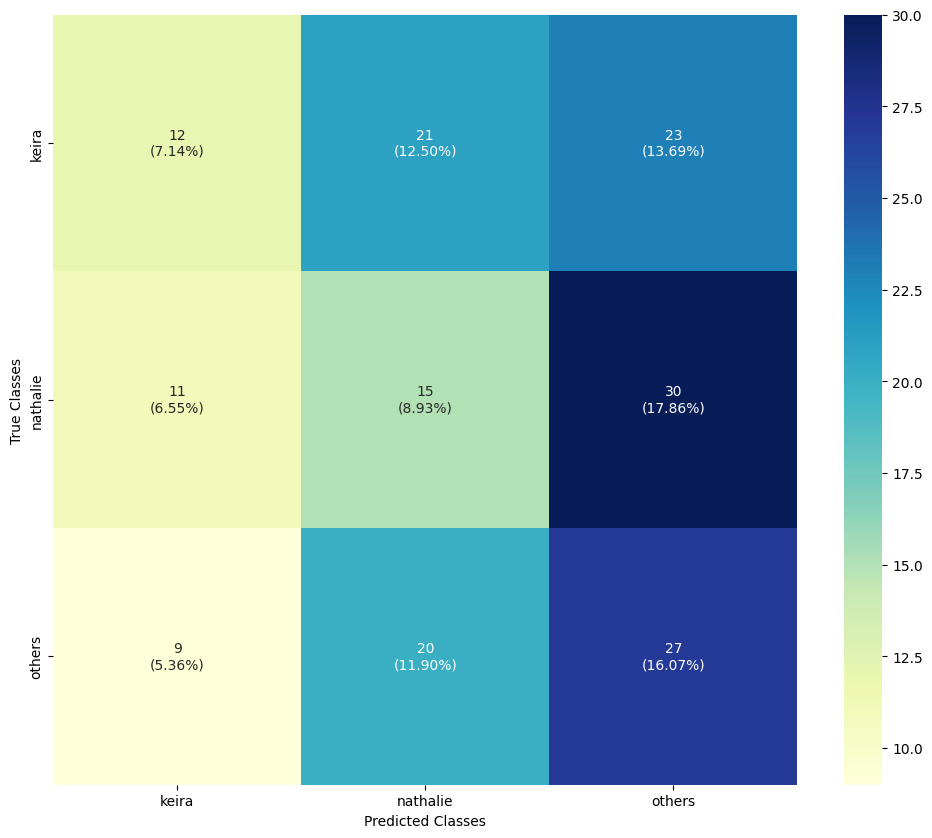

In [ ]:
# Importation de la bibliothèque Seaborn pour les visualisations
import seaborn as sns

# Génère la matrice de confusion à partir des classes vraies et prédites
cf_mtx = confusion_matrix(y_true, y_pred)

# Prépare les valeurs brutes (nombre d'exemples) dans chaque case de la matrice
group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]

# Calcule les pourcentages pour chaque case de la matrice
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]

# Combine les valeurs brutes et les pourcentages pour afficher dans chaque case du heatmap
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]

# Reshape en matrice 3x3 (car 3 classes dans ce cas)
box_labels = np.asarray(box_labels).reshape(3, 3)

# Crée une figure de taille 12x10 pouces
plt.figure(figsize = (12, 10))

# Affiche la matrice de confusion sous forme de heatmap avec Seaborn
sns.heatmap(cf_mtx,
            xticklabels=labels.values(),  # Noms des classes en abscisse
            yticklabels=labels.values(),  # Noms des classes en ordonnée
            cmap="YlGnBu",                # Palette de couleurs
            fmt="",                       # Format vide (car on fournit déjà des labels)
            annot=box_labels)            # Affiche les labels dans chaque case

# Ajoute un label pour l'axe X (classes prédites)
plt.xlabel('Predicted Classes')

# Ajoute un label pour l'axe Y (classes réelles)
plt.ylabel('True Classes')

# Affiche le graphique
plt.show()


In [ ]:
# Affiche un rapport détaillé de classification (précision, rappel, f1-score) pour chaque classe
print(classification_report(y_true, y_pred, target_names=labels.values()))


              precision    recall  f1-score   support

       keira       0.38      0.21      0.27        56
    nathalie       0.27      0.27      0.27        56
      others       0.34      0.48      0.40        56

    accuracy                           0.32       168
   macro avg       0.33      0.32      0.31       168
weighted avg       0.33      0.32      0.31       168



Les performances sont faibles avec une accuracy globale de 32%, reflétant des difficultés du modèle à distinguer clairement les trois classes.

# Data augmentation

In [ ]:
# Définition d'un modèle CNN simple avec 3 couches de convolution pour la classification en 3 classes
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

cnn_model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128),
    layers.Dense(units=3, activation='softmax')
])



In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = 224

# Définition du générateur de données avec augmentation
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                     horizontal_flip=True,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1)


In [ ]:
# Générateur pour les données d'entraînement
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                     horizontal_flip=True,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1)

# Générateur pour les données de validation (sans augmentation)
validation_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Chargement des données d'entraînement
train_data = train_generator.flow_from_directory(
        directory="/content/drive/My Drive/train",
        target_size=(image_size, image_size),
        class_mode='categorical')

# Chargement des données de validation (sans augmentation)
validation_data = validation_generator.flow_from_directory(
        directory="/content/drive/My Drive/val",
        target_size=(image_size, image_size),
        class_mode='categorical')


Found 429 images belonging to 3 classes.
Found 168 images belonging to 3 classes.


In [ ]:
# Compilation du modèle CNN avec l’optimiseur Adam, la perte entropie croisée catégorielle et la métrique d’exactitude
from tensorflow.keras.losses import CategoricalCrossentropy

cnn_model.compile(optimizer='adam',
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Définition de l'early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte de validation
    patience=5,          # Arrêter si aucune amélioration après 5 epochs
    restore_best_weights=True  # Restaurer les meilleurs poids trouvés
)

# Entraînement du modèle avec early stopping
epochs_size = 150
history = cnn_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=epochs_size,
    callbacks=[early_stopping]  # Ajout de l'early stopping
)



Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.3143 - loss: 4.2282 - val_accuracy: 0.3452 - val_loss: 1.0930
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.3590 - loss: 1.0982 - val_accuracy: 0.3810 - val_loss: 1.0999
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.3695 - loss: 1.0845 - val_accuracy: 0.4345 - val_loss: 1.0808
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.4621 - loss: 1.0571 - val_accuracy: 0.4345 - val_loss: 1.0733
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.4918 - loss: 1.0196 - val_accuracy: 0.4940 - val_loss: 1.0576
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.5179 - loss: 1.0197 - val_accuracy: 0.4643 - val_loss: 1.0695
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.5465 - loss: 0.9666 - val_accuracy: 0.5476 - val_loss: 1.0079
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5254 - loss: 0.8975 - val_accuracy: 0.4940 - v

In [ ]:
#  Extraction des valeurs de l'entraînement
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

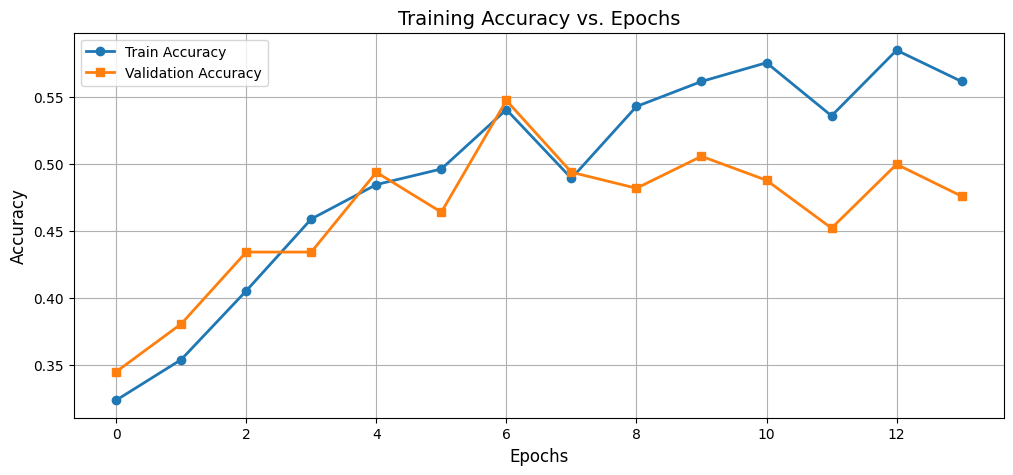

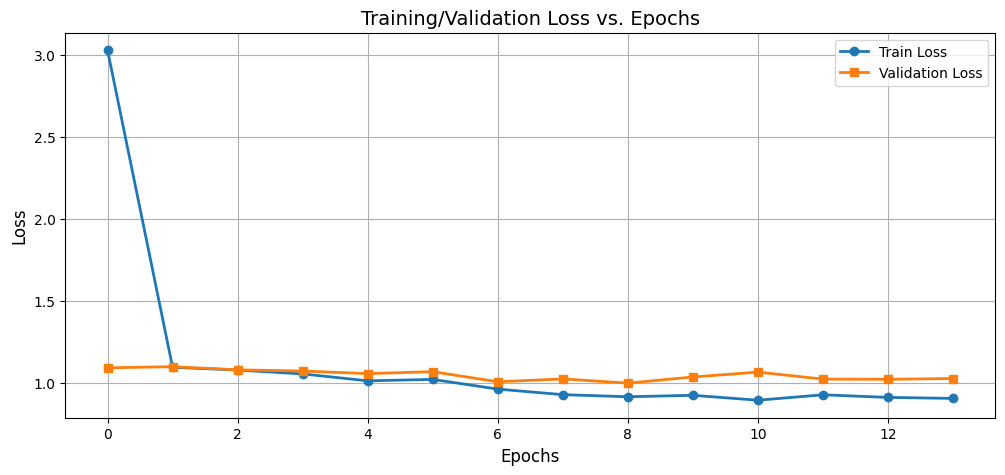

In [ ]:
import matplotlib.pyplot as plt

#  Graphique de l'Accuracy
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy, marker='o', linestyle='-', linewidth=2, label='Train Accuracy')
plt.plot(val_accuracy, marker='s', linestyle='-', linewidth=2, label='Validation Accuracy')
plt.title('Training Accuracy vs. Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid(True)  #  Ajout d'une grille
plt.show()

#  Graphique de la Loss
plt.figure(figsize=(12, 5))
plt.plot(train_loss, marker='o', linestyle='-', linewidth=2, label='Train Loss')
plt.plot(val_loss, marker='s', linestyle='-', linewidth=2, label='Validation Loss')
plt.title('Training/Validation Loss vs. Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='best')
plt.grid(True)  #  Ajout d'une grille
plt.show()


In [ ]:
# Chargement des données de test
test_generator = train_generator.flow_from_directory(
        directory="/content/drive/My Drive/test",
        target_size=(image_size, image_size),
        class_mode='categorical')


Found 168 images belonging to 3 classes.


In [ ]:
# Faire des prédictions sur les données de test
predictions = cnn_model.predict(test_generator)



6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator)


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4401 - loss: 1.0929


Les performances restent moyennes,nous allons maintenant voir un modele préentrainé

# Transfert Learning

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = 224  # Taille standard pour EfficientNetV2B1

# Générateur de données avec augmentation pour l'entraînement
train_generator = ImageDataGenerator(
    preprocessing_function=None,  # ResNet50 normalise lui-même les données
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2
)

# Générateur sans augmentation pour validation et test
validation_generator = ImageDataGenerator(preprocessing_function=None)
test_generator = ImageDataGenerator(preprocessing_function=None)

# Chargement des datasets
train_data = train_generator.flow_from_directory(
    directory=base_train_path,  # Correction du chemin
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

validation_data = validation_generator.flow_from_directory(
    directory=base_validation_path,  # Correction du chemin
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_generator.flow_from_directory(
    directory=base_test_path,  # Correction du chemin
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important pour éviter le warning de TensorFlow
)


Found 429 images belonging to 3 classes.
Found 168 images belonging to 3 classes.
Found 168 images belonging to 3 classes.


### Modèle pré-entraîné ResNet50 avec weights ='imagenet'

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Charger le modèle pré-entraîné sans la dernière couche
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Geler les couches du modèle pré-entraîné
base_model.trainable = False

# Ajouter de nouvelles couches pour adapter au dataset
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x)  # Adapter au nombre de classes

# Définir le modèle final
cnn_model = Model(inputs=base_model.input, outputs=output_layer)

# Compiler le modèle
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()  # Vérifier l'architecture


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,858,435 (91.01 MB)

 Trainable params: 270,723 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Entrainons le modèle

In [ ]:
# Entraînement du modèle avec early stopping pour arrêter si la perte de validation ne s'améliore plus après 5 epochs
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

epochs_size = 50

history = cnn_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=epochs_size,
    callbacks=[early_stopping]
)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 145s 9s/step - accuracy: 0.3355 - loss: 1.4777 - val_accuracy: 0.3750 - val_loss: 1.1961
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 122s 9s/step - accuracy: 0.4101 - loss: 1.0907 - val_accuracy: 0.3810 - val_loss: 1.0850
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 122s 9s/step - accuracy: 0.4891 - loss: 1.0286 - val_accuracy: 0.4345 - val_loss: 1.0710
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.5726 - loss: 0.9321 - val_accuracy: 0.4464 - val_loss: 1.0450
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 130s 10s/step - accuracy: 0.5327 - loss: 0.9615 - val_accuracy: 0.4702 - val_loss: 1.0236
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 122s 9s/step - accuracy: 0.6251 - loss: 0.8764 - val_accuracy: 0.4345 - val_loss: 1.0403
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 130s 9s/step - accuracy: 0.6691 - loss: 0.7958 - val_accuracy: 0.4881 - val_loss: 1.0056
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 122s 9s/step - accuracy: 0.6472 - loss: 0.8027 - val_accuracy: 0.5238 - 

In [ ]:
# Débloquer les 10 dernières couches du modèle pré-entraîné
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompiler avec un learning rate plus faible
cnn_model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Reprendre l'entraînement avec Fine-Tuning
history_fine_tune = cnn_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 151s 10s/step - accuracy: 0.7755 - loss: 0.6393 - val_accuracy: 0.5417 - val_loss: 0.9539
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 136s 10s/step - accuracy: 0.8024 - loss: 0.6051 - val_accuracy: 0.5357 - val_loss: 0.9619
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 135s 10s/step - accuracy: 0.7725 - loss: 0.6045 - val_accuracy: 0.5595 - val_loss: 0.9656
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 138s 10s/step - accuracy: 0.7827 - loss: 0.5906 - val_accuracy: 0.5595 - val_loss: 0.9656
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.8134 - loss: 0.5604 - val_accuracy: 0.5476 - val_loss: 0.9556
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 135s 10s/step - accuracy: 0.7987 - loss: 0.5691 - val_accuracy: 0.5417 - val_loss: 0.9552


### Évaluation du modèle

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.5105 - loss: 1.0788
Test Accuracy: 54.76%
Test Loss: 1.0006


## Utilisation de EfficientNetV2 pré-entraîné

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Charger le modèle EfficientNetV2 pré-entraîné sans la dernière couche
base_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle pré-entraîné
base_model.trainable = False

# Ajouter des couches personnalisées pour l’adaptation aux 3 classes
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(3, activation='softmax')(x)  # 3 classes

# Définir le modèle final
cnn_model = Model(inputs=base_model.input, outputs=output_layer)

# Compiler le modèle avec un learning rate adapté
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()  # Vérifier l'architecture


28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              0 │ rescaling_1[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 16)   │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 16)   │          2,304 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 16)   │             64 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 16)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 16)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 16)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_project_activ… │
├──────────────────────

 Total params: 7,292,343 (27.82 MB)

 Trainable params: 361,219 (1.38 MB)

 Non-trainable params: 6,931,124 (26.44 MB)

## Entraînons EfficientNetV2

In [ ]:
# Entraîne le modèle avec early stopping pour éviter le surapprentissage si la val_loss stagne pendant 5 epochs
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

epochs_size = 50  # Nombre d’epochs ajustable

history = cnn_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=epochs_size,
    callbacks=[early_stopping]
)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 99s 6s/step - accuracy: 0.3445 - loss: 1.1855 - val_accuracy: 0.3452 - val_loss: 1.1039
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.3910 - loss: 1.1206 - val_accuracy: 0.4464 - val_loss: 1.0792
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step - accuracy: 0.4185 - loss: 1.0813 - val_accuracy: 0.4524 - val_loss: 1.0642
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.4755 - loss: 1.0294 - val_accuracy: 0.4524 - val_loss: 1.0508
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.5297 - loss: 1.0054 - val_accuracy: 0.4762 - val_loss: 1.0352
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.4778 - loss: 1.0104 - val_accuracy: 0.5000 - val_loss: 1.0281
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.4975 - loss: 0.9917 - val_accuracy: 0.5179 - val_loss: 1.0194
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.5643 - loss: 0.9315 - val_accuracy: 0.5179 - val_loss:

### Fine-Tuning

In [ ]:
# Débloquer les 10 dernières couches d’EfficientNetV2
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompiler avec un learning rate plus faible
cnn_model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Reprendre l'entraînement avec Fine-Tuning
history_fine_tune = cnn_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=30,
    callbacks=[early_stopping]
)


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.7981 - loss: 0.6047 - val_accuracy: 0.5595 - val_loss: 0.8891
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.7818 - loss: 0.6152 - val_accuracy: 0.5595 - val_loss: 0.9071
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.8591 - loss: 0.5568 - val_accuracy: 0.5536 - val_loss: 0.9064
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.8082 - loss: 0.5984 - val_accuracy: 0.5595 - val_loss: 0.9067
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.8290 - loss: 0.5794 - val_accuracy: 0.5655 - val_loss: 0.9009
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.8140 - loss: 0.5537 - val_accuracy: 0.5655 - val_loss: 0.8990


### Évalions le Modèle sur les Données de Test

In [ ]:
# Évaluation finale sur le test
test_loss, test_accuracy = cnn_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5765 - loss: 0.9310
Test Accuracy: 57.74%
Test Loss: 0.9087


### Générer des Graphiques pour l’Analyse
Pour voir si le modèle s’améliore bien, on affiche les courbes d’apprentissage.

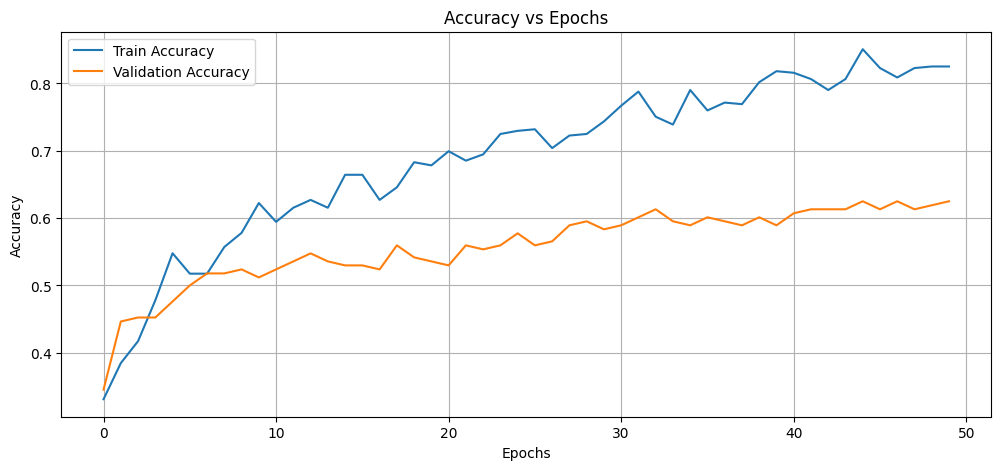

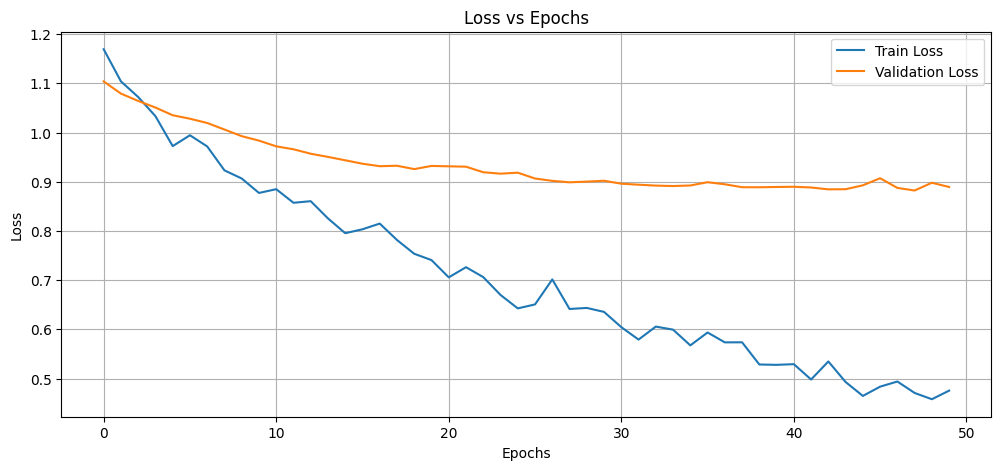

In [ ]:
import matplotlib.pyplot as plt

# Courbes de précision
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Courbes de perte
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Les graphiques de résultats montrent que l'accuracy d'entraînement continue de progresser, atteignant plus de 80 %, tandis que l'accuracy de validation stagne autour de 65 %, indiquant un risque de surapprentissage. La perte de validation diminue moins rapidement que celle de l'entraînement, suggérant que le modèle a du mal à généraliser.

Testons un dernier modele pré-entrainé

### Modèle EfficientNetB2 avec imagenet et un learning_rate important

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB2
from tensorflow import keras

# Définition des chemins de base dans Google Drive
base_train_path = "/content/drive/My Drive/train"
base_validation_path = "/content/drive/My Drive/val"
base_test_path = "/content/drive/My Drive/test"

# Définition des dimensions de l'image
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

# Générateur de données avec augmentation pour l'entraînement
train_generator = ImageDataGenerator(
    preprocessing_function=None,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2
)

# Générateur sans augmentation pour validation et test
validation_generator = ImageDataGenerator(preprocessing_function=None)
test_generator = ImageDataGenerator(preprocessing_function=None)

# Chargement des datasets
train_data = train_generator.flow_from_directory(
    directory=base_train_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

validation_data = validation_generator.flow_from_directory(
    directory=base_validation_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_generator.flow_from_directory(
    directory=base_test_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Définition du modèle EfficientNetB2
def build_model(num_classes=3):
    inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # Chargement d'EfficientNetB2 sans la couche finale
    base_model = EfficientNetB2(include_top=False, input_tensor=inputs, weights="imagenet")

    # Ajout des couches personnalisées
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Création du modèle final
    model = Model(inputs, outputs, name="EfficientNetB2_Custom")

    # Compilation du modèle
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Instanciation du modèle
model = build_model(num_classes=3)

# Définition du scheduler pour ajuster le learning rate
def scheduler(epoch, lr):
    if epoch == 0:
        return lr
    if (epoch % 10) == 0:
        return lr * 0.32
    else:
        return lr

# Callback pour ajuster le learning rate
schedule = keras.callbacks.LearningRateScheduler(scheduler)

# Définition du nombre d'époques
epochs = 30

# Entraînement du modèle
hist = model.fit(
    train_data,
    epochs=epochs,
    validation_data=validation_data,
    callbacks=[schedule]
)




Found 429 images belonging to 3 classes.
Found 168 images belonging to 3 classes.
Found 168 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 357s 18s/step - accuracy: 0.4162 - loss: 1.5255 - val_accuracy: 0.4107 - val_loss: 1.0850 - learning_rate: 5.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 254s 18s/step - accuracy: 0.7298 - loss: 0.6377 - val_accuracy: 0.5000 - val_loss: 1.0250 - learning_rate: 5.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 247s 17s/step - accuracy: 0.8571 - loss: 0.3916 - val_accuracy: 0.5774 - val_loss: 0.9298 - learning_rate: 5.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 256s 16s/step - accuracy: 0.9032 - loss: 0.3101 - val_accuracy: 0.6071 - val_loss: 0.8613 - learning_rate: 5.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 227s 16s/step - accuracy: 0.9361 - loss: 0.2300 - val_accuracy: 0.6012 - val_loss: 0.8879 - learning_rate: 5.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 227s 16s/step - accuracy: 0.9590 - loss: 0.1642 - val_accuracy: 0.6488 - val_loss: 0.7446 - learning_rate: 5.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 227s 16s/step - accuracy: 

In [ ]:
# Évaluation du modèle sur l'ensemble de test
score = model.evaluate(test_data)

# Affichage des résultats
print(f"Test Loss: {score[0]:.4f}")
print(f"Test Accuracy: {score[1]:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7341 - loss: 1.1036
Test Loss: 1.0374
Test Accuracy: 0.7560


Le modèle atteint une bonne performance avec une accuracy de 75.6 % malgré une perte encore relativement élevée.

In [ ]:
import numpy as np

# Prédiction sur l'ensemble de test
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)  # Classes prédites
y_true = test_data.classes  # Classes réelles

# Labels des classes
class_labels = list(test_data.class_indices.keys())



6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step


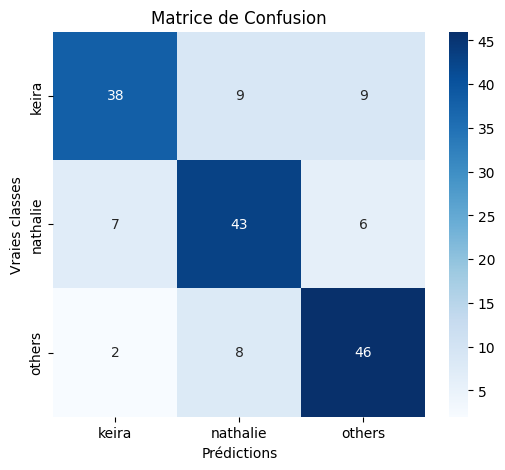

In [ ]:
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Affichage de la matrice de confusion
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()



On remarque pour Keira,38 images sont bien classées alors que 9 confondues avec Nathalie et 9 sont confondues avec les autres.
Pour Nathalie c'est 43 images qui sont bien classées alors que 7 sont confondues avec keira, et 6 sont confondues avec les autres actrices.
Enfin concernant les autres actrices,le modèle reussit a classées 46 images correctement alots qu'il confond 2 images avec Keira et 8 sont confondues avec Nathalie. On conclue que le modèle reste perfectible,cependant il est très satisfaisant.

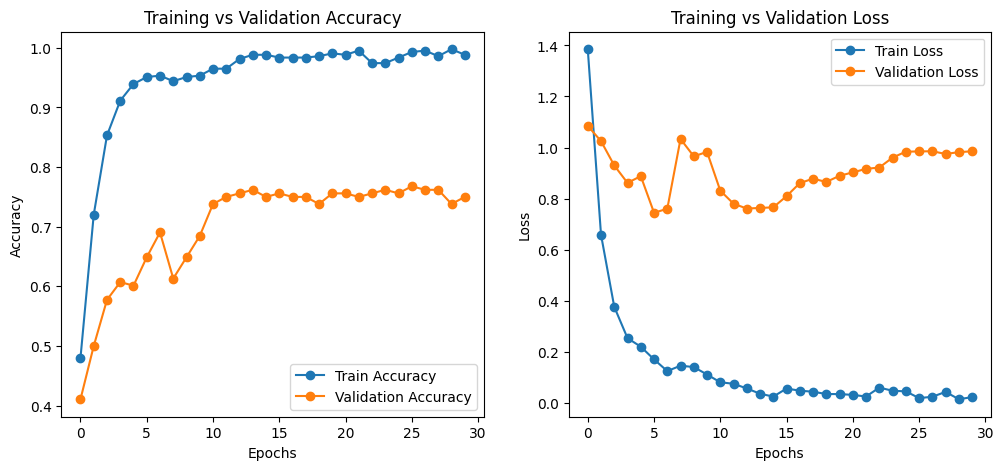

In [ ]:
# Récupération des métriques
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Définir la plage d’epochs pour l’axe X
epochs_range = range(len(train_accuracy))

# Affichage des courbes
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, 'o-', label='Train Accuracy')
plt.plot(epochs_range, val_accuracy, 'o-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, 'o-', label='Train Loss')
plt.plot(epochs_range, val_loss, 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()


### Conclusion génerale
L’évaluation des modèles montre que l’utilisation de réseaux pré-entraînés améliore significativement les performances par rapport à un CNN de base. EfficientNetB2 offre la meilleure précision avec 75,6 % en test, surpassant ResNet50 (54,76%) et EfficientNetV2B1 (57,74%), bien que son temps d'entraînement soit légèrement plus long. Le CNN simple reste en deçà des attentes, et la data augmentation seule ne permet pas d’améliorer les performances. Ces résultats confirment l’intérêt du transfert learning, notamment avec EfficientNetB2, pour ce type de classification d’images. ​

### Perspectives pour les futurs travaux

Ce projet peut être enrichi et approfondi par les futurs étudiants à travers plusieurs pistes d’amélioration. Tout d’abord, l’augmentation du dataset est une voie essentielle : en élargissant la base d’images, le modèle pourrait gagner en robustesse et améliorer sa capacité de généralisation. Ensuite, un fine-tuning progressif du modèle EfficientNetB2, en dégelant progressivement certaines couches, permettrait d’adapter davantage les représentations apprises aux spécificités du jeu de données. Enfin, une perspective intéressante serait le développement d’une interface utilisateur (par exemple via Streamlit) permettant de charger une image et d’obtenir une prédiction, afin de rendre le projet interactif, concret et facilement testable.